# 作业四：室内小物体目标检测

| 姓名 | 学号 |
| :--: | :--: |
| 刘翎 | 1120202969 |
| 陈雪峰 | 1120201545 |
| 马梓奥 | 1120202685 |
| 邓雅萱 | 1120202004 |
| 王子默 | 1120202440 |



## 项目介绍
本项目参加了codalab的[北理2022春深度学习目标检测比赛](https://codalab.lisn.upsaclay.fr/competitions/5178?secret_key=9aa6e348-cc0c-4ec3-836c-7306fb158c5b#results)，user名为deep_learning_study_group，使用了本项目所训练的模型进行test，并最终取得了mAP为**0.4070**的结果，暂居榜单**第三**。

本次实验使用的Cascade R-CNN的网络模型，参照了论文[Cascade R-CNN: Delving into High Quality Object Detection](https://arxiv.org/abs/1712.00726)，具体实现参考了[mmdetection框架](https://github.com/open-mmlab/mmdetection)，套用```cascade_rcnn_r50_fpn```的结构，并采用codalab比赛提供的coco部分数据集，实现了目标检测。

**Cascade R-CNN**是一种多阶段目标检测器，在各阶段训练出该阶段适合的IoU阈值，从而组合成多个级联的检测器。其网络结构如图所示：


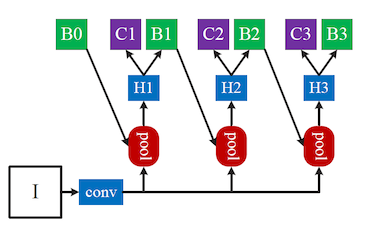

其中```conv```表示卷积神经网络；```pool```表示池化层；$B0$表示proposal；$B1, B2, B3$表示bounding box；$H1, H2, H3$表示detection head；$C1, C2, C3$表示分类器。





项目模型得到的目标检测的部分结果如下：
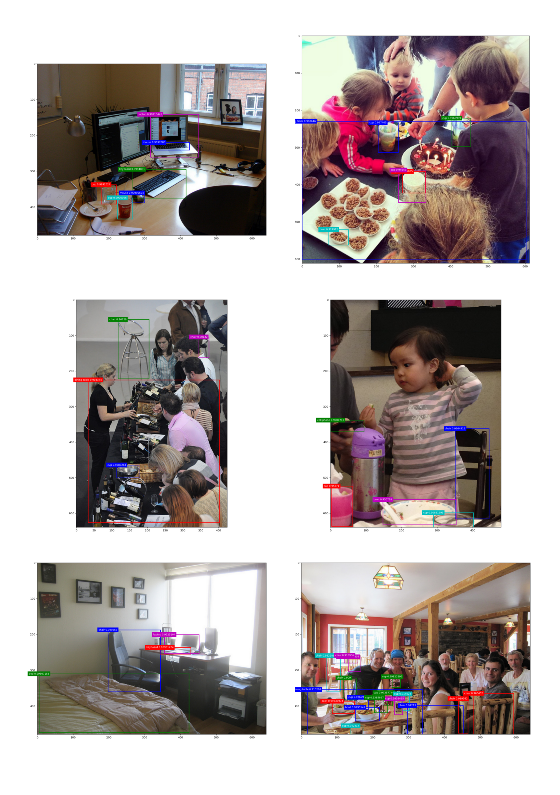

## 导入相关包
本项目仍然依赖于mmcv和mmdet中的部分功能，故运行前需要安装mmcv-full和mmdet。

In [ ]:
import os
import csv
import json
import copy
import time
import mmcv
import torch
import datetime
import numpy as np
import torch.optim
from nms import nms
import torch.nn as nn
from PIL import Image
from functools import partial
from mmcv.ops.nms import NMSop
import torch.nn.functional as F
from matplotlib import pyplot as plt
from mmdet.datasets import build_dataloader
from mmdet.core import bbox_mapping_back, multi_apply
from mmdet.datasets.coco import CocoDataset as _CocoDataset

## 标注文件的格式转换

为了获得图片的标注信息，先导入json文件，并转换获得以下信息：
* bounding box边界信息 (x,y,w,h)
* 所属类别信息class

In [ ]:
def make_anno():
    data_root = 'data/'
    anno_path = data_root + 'annotations/original_train.json'
    train_anno_path = data_root + 'annotations/train.json'
    test_anno_path = data_root + 'annotations/test.json'

    # train annotations
    with open(anno_path, 'r') as f:
        train_anno = json.load(f)

    ori_bboxes = train_anno['annotations']
    for anno in ori_bboxes:
        x, y, w, h = anno['bbox']
        anno['bbox'] = [x, y, w, h]
        anno['segmentation'] = [[x, y, x + w, y, x + w, y + h, x, y + h]]
        anno['area'] = w * h
        anno['category_id'] += 1
        anno['iscrowd'] = 0

    categories = train_anno['categories']
    for category in categories:
        category['id'] += 1
        category['supercategory'] = 'None'

    with open(train_anno_path, 'w') as f:
        json.dump(train_anno, f, indent=1, separators=(',', ': '))

    # test annotations
    img_list = []
    for i in range(33354, 49716):
        filename = '00' + str(i) + '.jpg'
        img = cv2.imread(data_root + 'test/' + filename)
        img_info = dict(
            file_name=filename,
            height=img.shape[0],
            width=img.shape[1],
            id=i
        )
        img_list.append(img_info)

    test_anno = dict(
        info=train_anno['info'],
        images=img_list,
        annotations=[],
        categories=train_anno['categories']
    )

    with open(test_anno_path, 'w') as f:
        json.dump(test_anno, f, indent=1, separators=(',', ':'))

make_anno()

## 0. 模型配置
项目的数据文件夹结构如下：
```
├──annotations
│   ├── original_train.json(助教提供的标注文件)
│   ├── train.json
│   ├── test.json
├── train(存放训练集图片)
├── test(存放测试集图片)
```

In [ ]:
# 设置图像归一化分布参数
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)

data_root = 'data/'
classes = (
    "backpack", "cup", "bowl", "banana", "apple", "orange", "chair", "couch", "potted plant", "bed", "dining table",
    "laptop", "mouse", "keyboard", "cell phone", "book", "clock", "vase", "scissors", "hair drier", "toothbrush"
)
# 训练和测试参数设置
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ]
    )
]
# 加载train test数据集的标注信息
train_data_config = dict(
    ann_file=data_root + 'annotations/train.json',
    pipeline=train_pipeline,
    img_prefix=data_root + 'train/'
)
val_data_config = dict(
    ann_file=data_root + 'annotations/train.json',
    pipeline=test_pipeline,
    img_prefix=data_root + 'train/'
)
test_data_config = dict(
    ann_file=data_root + 'annotations/test.json',
    pipeline=test_pipeline,
    img_prefix=data_root + 'test/'
)
test_result_path = './Prediction/'
model_path = './Model/'
# 网络模型参数设置
model = dict(
    type='CascadeRCNN',
    backbone=dict(type='ResNet50', width=1),
    neck=dict(type='FPN', in_channels=[256, 512, 1024, 2048], out_channels=256, num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(type='AnchorGenerator', scales=[8], ratios=[0.5, 1.0, 2.0], strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(type='DeltaXYWHBBoxCoder', target_means=[.0, .0, .0, .0], target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='SmoothL1Loss', beta=1.0 / 9.0, loss_weight=1.0)),
    roi_head=dict(
        type='CascadeRoIHead',
        num_stages=3,
        stage_loss_weights=[1, 0.5, 0.25],
        bbox_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=7, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        bbox_head=[
            dict(
                type='Shared2FCBBoxHead',
                in_channels=256,
                fc_out_channels=1024,
                roi_feat_size=7,
                num_classes=21,
                bbox_coder=dict(type='DeltaXYWHBBoxCoder', target_means=[0., 0., 0., 0.], target_stds=[0.1, 0.1, 0.2, 0.2]),
                reg_class_agnostic=True,
                loss_cls=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
                loss_bbox=dict(type='SmoothL1Loss', beta=1.0, loss_weight=1.0)),
            dict(
                type='Shared2FCBBoxHead',
                in_channels=256,
                fc_out_channels=1024,
                roi_feat_size=7,
                num_classes=21,
                bbox_coder=dict(type='DeltaXYWHBBoxCoder', target_means=[0., 0., 0., 0.], target_stds=[0.05, 0.05, 0.1, 0.1]),
                reg_class_agnostic=True,
                loss_cls=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
                loss_bbox=dict(type='SmoothL1Loss', beta=1.0, loss_weight=1.0)),
            dict(
                type='Shared2FCBBoxHead',
                in_channels=256,
                fc_out_channels=1024,
                roi_feat_size=7,
                num_classes=21,
                bbox_coder=dict(type='DeltaXYWHBBoxCoder', target_means=[0., 0., 0., 0.], target_stds=[0.033, 0.033, 0.067, 0.067]),
                reg_class_agnostic=True,
                loss_cls=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
                loss_bbox=dict(type='SmoothL1Loss', beta=1.0, loss_weight=1.0))
        ]),
    train_cfg=dict(
        rpn=dict(
            assigner=dict(type='MaxIoUAssigner', pos_iou_thr=0.7, neg_iou_thr=0.3, min_pos_iou=0.3, match_low_quality=True, ignore_iof_thr=-1),
            sampler=dict(type='RandomSampler', num=256, pos_fraction=0.5, neg_pos_ub=-1, add_gt_as_proposals=False),
            allowed_border=0,
            pos_weight=-1,
            debug=False),
        rpn_proposal=dict(nms_pre=2000, max_per_img=2000, nms=dict(type='nms', iou_threshold=0.7), min_bbox_size=0),
        rcnn=[
            dict(
                assigner=dict(type='MaxIoUAssigner', pos_iou_thr=0.5, neg_iou_thr=0.5, min_pos_iou=0.5, match_low_quality=False, ignore_iof_thr=-1),
                sampler=dict(type='RandomSampler', num=512, pos_fraction=0.25, neg_pos_ub=-1, add_gt_as_proposals=True),
                pos_weight=-1,
                debug=False),
            dict(
                assigner=dict(type='MaxIoUAssigner', pos_iou_thr=0.6, neg_iou_thr=0.6, min_pos_iou=0.6, match_low_quality=False, ignore_iof_thr=-1),
                sampler=dict(type='RandomSampler', num=512, pos_fraction=0.25, neg_pos_ub=-1, add_gt_as_proposals=True),
                pos_weight=-1,
                debug=False),
            dict(
                assigner=dict(type='MaxIoUAssigner', pos_iou_thr=0.7, neg_iou_thr=0.7, min_pos_iou=0.7, match_low_quality=False, ignore_iof_thr=-1),
                sampler=dict(type='RandomSampler', num=512, pos_fraction=0.25, neg_pos_ub=-1, add_gt_as_proposals=True),
                pos_weight=-1,
                debug=False)
        ]),
    test_cfg=dict(
        rpn=dict(nms_pre=1000, max_per_img=1000, nms=dict(type='nms', iou_threshold=0.7), min_bbox_size=0),
        rcnn=dict(score_thr=0.05, nms=dict(type='nms', iou_threshold=0.5), max_per_img=100, mask_thr_binary=0.5)))
epoch_num = 50

## 1. 特征提取部分

### 1.1 特征提取骨干网络：ResNet50

本项目采用的两阶段目标检测器以ResNet50+FPN作为特征提取模块。Resnet50部分实现了以下内容：
* ResNet50的Bottleneck残差块
* ResNetLayer层级结构
* ResNet50整体实现。

为提取多尺度特征以传入FPN进行进一步的特征提取，在此将ResNet50的每一个层级的输出组合成列表，作为backbone部分的输出。

In [ ]:
# bottleneck残差块
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=False, width=1):
        super(Bottleneck, self).__init__()
        bottleneck_channels = width * out_channels // 4
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=bottleneck_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=bottleneck_channels)
        self.conv2 = nn.Conv2d(in_channels=bottleneck_channels, out_channels=bottleneck_channels, kernel_size=3, stride=stride, padding=1， bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=bottleneck_channels)
        self.conv3 = nn.Conv2d(in_channels=bottleneck_channels, out_channels=out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        if downsample is True:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(num_features=out_channels)
            )
        else:
            self.downsample = None
        self.stride = stride

    def __call__(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

# resnet的层级结构实现
class ResNetLayer(nn.Sequential):
    def __init__(self, in_channels, blocks, stride=None, out_channels=None, fisrt_layer_downsample=True, width=1):
        layers = [Bottleneck(in_channels=in_channels, out_channels=out_channels, stride=stride, downsample=True, width=width)]
        for _ in range(1, blocks):
            layers.append(Bottleneck(in_channels=out_channels, out_channels=out_channels, width=width))
        super(ResNetLayer, self).__init__(*layers)

# resnet50
class ResNet50(nn.Module):
    def __init__(self, config):
        super(ResNet50, self).__init__()
        width = config['width']
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = ResNetLayer(in_channels=64, out_channels=256, blocks=3, stride=1, width=width)
        self.layer2 = ResNetLayer(in_channels=256, out_channels=512, blocks=4, stride=2, width=width)
        self.layer3 = ResNetLayer(in_channels=512, out_channels=1024, blocks=6, stride=2, width=width)
        self.layer4 = ResNetLayer(in_channels=1024, out_channels=2048, blocks=3, stride=2, width=width)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        layer1_out = self.layer1(x)
        layer2_out = self.layer2(layer1_out)
        layer3_out = self.layer3(layer2_out)
        layer4_out = self.layer4(layer3_out)

        return [layer1_out, layer2_out, layer3_out, layer4_out]

### 1.2 特征金字塔网络：FPN

鉴于我们本次目标是完成小物体的检测，考虑到使用单尺度特征图进行目标检测易丢失细节特征的信息。为了更好的实现多尺度目标检测，我们将**特征金字塔网络(Feature Pyramid Networks, FPN)**作为neck部分，具体原理介绍如下
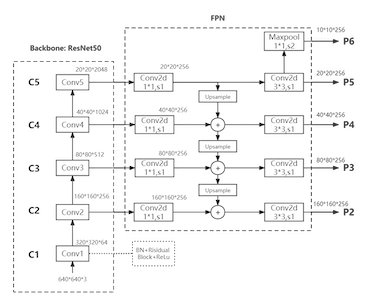
FPN读取的输入来自ResNet网络的输出，具体过程如下：

* 首先进行横向卷积，即使用$1*1$卷积层规范每一层规范每一层的通道数。此时相邻层之间通道数相同，宽高分别为$2$倍关系。
* 接着，对高层的特征图进行上采样（插值），使得相邻两侧的宽高相同；
* 然后，通过对应元素相加，将上采样映射和横向卷积的输出合并，得到新的特征图。
* 最后，各个新的特征图再经过$3*3$卷积层进行计算，得到四个输出分别为$P2,P3,P4,P5,$特别的，对P5进行下采样（步长为$2$的$*1$池化层），得到$P6$。

In [ ]:
class FPN(nn.Module):
    def __init__(self, config):
        super(FPN, self).__init__()
        in_channels = config['in_channels']
        out_channels = config['out_channels']
        self.num_outs = config['num_outs']
        self.lateral_convs = nn.ModuleList()
        self.fpn_convs = nn.ModuleList()

        for i in range(len(in_channels)):
            l_conv = nn.Conv2d(in_channels=in_channels[i], out_channels=out_channels, kernel_size=1)
            fpn_conv = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)
            self.lateral_convs.append(l_conv)
            self.fpn_convs.append(fpn_conv)

    def forward(self, inputs):
        laterals = [lateral_conv(inputs[i]) for i, lateral_conv in enumerate(self.lateral_convs)]

        used_backbone_levels = len(laterals)
        for i in range(used_backbone_levels - 1, 0, -1):
            prev_shape = laterals[i - 1].shape[2:]
            laterals[i - 1] = laterals[i - 1] + F.interpolate(laterals[i], size=prev_shape)

        outs = [self.fpn_convs[i](laterals[i]) for i in range(used_backbone_levels)]

        if self.num_outs > len(outs):
            for i in range(self.num_outs - used_backbone_levels):
                outs.append(F.max_pool2d(outs[-1], 1, stride=2))

        return tuple(outs)

## 2. 区域候选网络：RPN

接收来自特征提取网络的多尺度图像特征，在特征图上生成大量锚框，对锚框进行回归、分配、筛选，得到每张特征图对应的候选区域。

In [ ]:
class RPNHead(nn.Module):
    def __init__(self, config, train_cfg, test_cfg):
        super(RPNHead, self).__init__()
        self.num_classes = 21
        self.train_cfg = train_cfg
        self.test_cfg = test_cfg
        self.in_channels = config['in_channels']
        self.feat_channels = config['feat_channels']

        self.rpn_conv = nn.Conv2d(in_channels=config['in_channels'], out_channels=config['feat_channels'], kernel_size=3, padding=1)
        self.rpn_cls = nn.Conv2d(in_channels=config['feat_channels'], out_channels=3, kernel_size=1)
        self.rpn_reg = nn.Conv2d(in_channels=config['feat_channels'], out_channels=12, kernel_size=1)

        self.bbox_coder = BBoxCoder(config['bbox_coder'])
        self.loss_cls = CrossEntropyLoss(use_sigmoid=config['loss_cls']['use_sigmoid'], loss_weight=config['loss_cls']['loss_weight'])
        self.loss_bbox = SmoothL1Loss(beta=config['loss_bbox']['beta'], loss_weight=config['loss_bbox']['loss_weight'])
        self.prior_generator = AnchorGenerator(config['anchor_generator'])
        self.assigner = Assigner(self.train_cfg['rpn']['assigner'])
        self.sampler = RandomSampler(self.train_cfg['rpn']['sampler'])

        self.use_sigmoid_cls = config['loss_cls']['use_sigmoid']
        
    # 前向传播
    def forward_single(self, x):
        x = self.rpn_conv(x)
        x = F.relu(x, inplace=True)
        rpn_cls_score = self.rpn_cls(x)
        rpn_bbox_pred = self.rpn_reg(x)
        return rpn_cls_score, rpn_bbox_pred

    def forward(self, feats):
        return multi_apply(self.forward_single, feats)

    def forward_train(self, x, img_metas, gt_bboxes, proposal_cfg=None):
        outs = self(x)
        loss_inputs = outs + (gt_bboxes, img_metas)
        losses = self.loss(*loss_inputs)
        proposal_list = self.get_bboxes(*outs, img_metas=img_metas, cfg=proposal_cfg)
        return losses, proposal_list

    # 计算类别loss和bounding box loss
    def loss_single(self, cls_score, bbox_pred, labels, label_weights,
                    bbox_targets, bbox_weights, num_total_samples):
        labels = labels.reshape(-1)
        label_weights = label_weights.reshape(-1)
        cls_score = cls_score.permute(0, 2, 3, 1).reshape(-1, 1)
        loss_cls = self.loss_cls(cls_score, labels, label_weights, avg_factor=num_total_samples)

        bbox_targets = bbox_targets.reshape(-1, 4)
        bbox_weights = bbox_weights.reshape(-1, 4)
        bbox_pred = bbox_pred.permute(0, 2, 3, 1).reshape(-1, 4)

        loss_bbox = self.loss_bbox(bbox_pred, bbox_targets, bbox_weights, avg_factor=num_total_samples)
        return loss_cls, loss_bbox

    def loss(self, cls_scores, bbox_preds, gt_bboxes, img_metas):
        featmap_sizes = [featmap.size()[-2:] for featmap in cls_scores]

        device = cls_scores[0].device

        anchor_list, valid_flag_list = self.get_anchors(featmap_sizes, img_metas, device=device)
        cls_reg_targets = self.get_targets(anchor_list, valid_flag_list, gt_bboxes, img_metas)
        if cls_reg_targets is None:
            return None
        (labels_list, label_weights_list, bbox_targets_list, bbox_weights_list, num_total_pos, num_total_neg) = cls_reg_targets
        num_total_samples = num_total_pos + num_total_neg

        concat_anchor_list = []
        for i in range(len(anchor_list)):
            concat_anchor_list.append(torch.cat(anchor_list[i]))

        losses_cls, losses_bbox = multi_apply(self.loss_single, cls_scores, bbox_preds, labels_list, label_weights_list, bbox_targets_list, bbox_weights_list, num_total_samples=num_total_samples)
        return dict(loss_cls=losses_cls, loss_bbox=losses_bbox)

    # 获得锚框
    def get_anchors(self, featmap_sizes, img_metas, device='cuda'):
        num_imgs = len(img_metas)

        multi_level_anchors = self.prior_generator.grid_priors(featmap_sizes, device=device)
        anchor_list = [multi_level_anchors for _ in range(num_imgs)]

        valid_flag_list = []
        for img_id, img_meta in enumerate(img_metas):
            multi_level_flags = self.prior_generator.valid_flags(featmap_sizes, img_meta['pad_shape'], device)
            valid_flag_list.append(multi_level_flags)

        return anchor_list, valid_flag_list

    def _get_targets_single(self, flat_anchors, valid_flags, gt_bboxes, img_meta):
        inside_flags = self.anchor_inside_flags(flat_anchors, valid_flags, img_meta['img_shape'][:2])
        if not inside_flags.any():
            return (None,) * 7
        
        anchors = flat_anchors[inside_flags, :]

        assign_result = self.assigner.assign(anchors, gt_bboxes)
        sampling_result = self.sampler.sample(assign_result, anchors, gt_bboxes)

        num_valid_anchors = anchors.shape[0]
        bbox_targets = torch.zeros_like(anchors)
        bbox_weights = torch.zeros_like(anchors)
        labels = anchors.new_full((num_valid_anchors,), self.num_classes, dtype=torch.long)
        label_weights = anchors.new_zeros(num_valid_anchors, dtype=torch.float)

        pos_inds = sampling_result.pos_inds
        neg_inds = sampling_result.neg_inds
        if len(pos_inds) > 0:
            pos_bbox_targets = self.bbox_coder.encode(sampling_result.pos_bboxes, sampling_result.pos_gt_bboxes)
            bbox_targets[pos_inds, :] = pos_bbox_targets
            bbox_weights[pos_inds, :] = 1.0
            labels[pos_inds] = 0
            if self.train_cfg['rpn']['pos_weight'] <= 0:
                label_weights[pos_inds] = 1.0
            else:
                label_weights[pos_inds] = self.train_cfg['rpn']['pos_weight']
        if len(neg_inds) > 0:
            label_weights[neg_inds] = 1.0

        num_total_anchors = flat_anchors.size(0)
        labels = self.unmap(labels, num_total_anchors, inside_flags, fill=self.num_classes)
        label_weights = self.unmap(label_weights, num_total_anchors, inside_flags)
        bbox_targets = self.unmap(bbox_targets, num_total_anchors, inside_flags)
        bbox_weights = self.unmap(bbox_weights, num_total_anchors, inside_flags)

        return (labels, label_weights, bbox_targets, bbox_weights, pos_inds, neg_inds, sampling_result)

    def get_targets(self, anchor_list, valid_flag_list, gt_bboxes_list, img_metas):
        num_imgs = len(img_metas)
        num_level_anchors = [anchors.size(0) for anchors in anchor_list[0]]

        concat_anchor_list = []
        concat_valid_flag_list = []
        for i in range(num_imgs):
            concat_anchor_list.append(torch.cat(anchor_list[i]))
            concat_valid_flag_list.append(torch.cat(valid_flag_list[i]))

        results = multi_apply(self._get_targets_single, concat_anchor_list, concat_valid_flag_list, gt_bboxes_list, img_metas)
        (all_labels, all_label_weights, all_bbox_targets, all_bbox_weights, pos_inds_list, neg_inds_list, sampling_results_list) = results
        
        if any([labels is None for labels in all_labels]):
            return None
        
        num_total_pos = sum([max(inds.numel(), 1) for inds in pos_inds_list])
        num_total_neg = sum([max(inds.numel(), 1) for inds in neg_inds_list])
        
        labels_list = self.images_to_levels(all_labels, num_level_anchors)
        label_weights_list = self.images_to_levels(all_label_weights, num_level_anchors)
        bbox_targets_list = self.images_to_levels(all_bbox_targets, num_level_anchors)
        bbox_weights_list = self.images_to_levels(all_bbox_weights, num_level_anchors)
        res = (labels_list, label_weights_list, bbox_targets_list, bbox_weights_list, num_total_pos, num_total_neg)
        return res

    def get_bboxes(self, cls_scores,  bbox_preds, img_metas=None, cfg=None):
        num_levels = len(cls_scores)

        featmap_sizes = [cls_scores[i].shape[-2:] for i in range(num_levels)]
        mlvl_priors = self.prior_generator.grid_priors(featmap_sizes, dtype=cls_scores[0].dtype, device=cls_scores[0].device)

        result_list = []

        for img_id in range(len(img_metas)):
            img_meta = img_metas[img_id]
            cls_score_list = self.select_single_mlvl(cls_scores, img_id)
            bbox_pred_list = self.select_single_mlvl(bbox_preds, img_id)

            results = self._get_bboxes_single(cls_score_list, bbox_pred_list, mlvl_priors, img_meta, cfg)
            result_list.append(results)
        return result_list

    def _get_bboxes_single(self, cls_score_list, bbox_pred_list, mlvl_anchors, img_meta, cfg):
        cfg = self.train_cfg['rpn_proposal'] if cfg is None else cfg
        cfg = copy.deepcopy(cfg)
        img_shape = img_meta['img_shape']

        level_ids = []
        mlvl_scores = []
        mlvl_bbox_preds = []
        mlvl_valid_anchors = []
        nms_pre = cfg.get('nms_pre', -1)
        for level_idx in range(len(cls_score_list)):
            rpn_cls_score = cls_score_list[level_idx]
            rpn_bbox_pred = bbox_pred_list[level_idx]
            rpn_cls_score = rpn_cls_score.permute(1, 2, 0)
            if self.use_sigmoid_cls:
                rpn_cls_score = rpn_cls_score.reshape(-1)
                scores = rpn_cls_score.sigmoid()
            else:
                rpn_cls_score = rpn_cls_score.reshape(-1, 2)
                scores = rpn_cls_score.softmax(dim=1)[:, 0]
            rpn_bbox_pred = rpn_bbox_pred.permute(1, 2, 0).reshape(-1, 4)

            anchors = mlvl_anchors[level_idx]
            if 0 < nms_pre < scores.shape[0]:
                ranked_scores, rank_inds = scores.sort(descending=True)
                topk_inds = rank_inds[:nms_pre]
                scores = ranked_scores[:nms_pre]
                rpn_bbox_pred = rpn_bbox_pred[topk_inds, :]
                anchors = anchors[topk_inds, :]

            mlvl_scores.append(scores)
            mlvl_bbox_preds.append(rpn_bbox_pred)
            mlvl_valid_anchors.append(anchors)
            level_ids.append(scores.new_full((scores.size(0),), level_idx, dtype=torch.long))

        return self._bbox_post_process(mlvl_scores, mlvl_bbox_preds, mlvl_valid_anchors, level_ids, cfg, img_shape)

    def _bbox_post_process(self, mlvl_scores, mlvl_bboxes, mlvl_valid_anchors, level_ids, cfg, img_shape):
        scores = torch.cat(mlvl_scores)
        anchors = torch.cat(mlvl_valid_anchors)
        rpn_bbox_pred = torch.cat(mlvl_bboxes)
        proposals = self.bbox_coder.decode(anchors, rpn_bbox_pred, max_shape=img_shape)
        ids = torch.cat(level_ids)
        w = proposals[:, 2] - proposals[:, 0]
        h = proposals[:, 3] - proposals[:, 1]
        valid_mask = (w > cfg['min_bbox_size']) & (h > cfg['min_bbox_size'])
        if not valid_mask.all():
            proposals = proposals[valid_mask]
            scores = scores[valid_mask]
            ids = ids[valid_mask]
        if proposals.numel() > 0:
            dets, _ = self.batched_nms(proposals, scores, ids, cfg['nms'])
        else:
            return proposals.new_zeros(0, 5)
        return dets[:cfg['max_per_img']]

    # test
    def simple_test_rpn(self, x, img_metas):
        rpn_outs = self(x)
        proposal_list = self.get_bboxes(*rpn_outs, img_metas=img_metas)
        return proposal_list

    def aug_test_rpn(self, feats, img_metas):
        samples_per_gpu = len(img_metas[0])
        aug_proposals = [[] for _ in range(samples_per_gpu)]
        for x, img_meta in zip(feats, img_metas):
            proposal_list = self.simple_test_rpn(x, img_meta)
            for i, proposals in enumerate(proposal_list):
                aug_proposals[i].append(proposals)

        aug_img_metas = []
        for i in range(samples_per_gpu):
            aug_img_meta = []
            for j in range(len(img_metas)):
                aug_img_meta.append(img_metas[j][i])
            aug_img_metas.append(aug_img_meta)

        merged_proposals = [self.merge_aug_proposals(proposals, aug_img_meta, self.test_cfg['rpn']) for proposals, aug_img_meta in zip(aug_proposals, aug_img_metas)]
        return merged_proposals
    
    @staticmethod
    def anchor_inside_flags(flat_anchors, valid_flags, img_shape, allowed_border=0):
        img_h, img_w = img_shape[:2]
        if allowed_border >= 0:
            inside_flags = valid_flags & (flat_anchors[:, 0] >= -allowed_border) & (flat_anchors[:, 1] >= -allowed_border) & \
                (flat_anchors[:, 2] < img_w + allowed_border) & (flat_anchors[:, 3] < img_h + allowed_border)
        else:
            inside_flags = valid_flags
        return inside_flags

    @staticmethod
    def merge_aug_proposals(aug_proposals, img_metas, cfg):
        cfg = copy.deepcopy(cfg)
        recovered_proposals = []
        for proposals, img_info in zip(aug_proposals, img_metas):
            img_shape = img_info['img_shape']
            scale_factor = img_info['scale_factor']
            flip = img_info['flip']
            flip_direction = img_info['flip_direction']
            _proposals = proposals.clone()
            _proposals[:, :4] = bbox_mapping_back(_proposals[:, :4], img_shape, scale_factor, flip, flip_direction)
            recovered_proposals.append(_proposals)
        aug_proposals = torch.cat(recovered_proposals, dim=0)
        merged_proposals, _ = self.nms(aug_proposals[:, :4].contiguous(), aug_proposals[:, -1].contiguous(), cfg['nms']['iou_threshold'])
        scores = merged_proposals[:, 4]
        _, order = scores.sort(0, descending=True)
        num = min(cfg['max_per_img'], merged_proposals.shape[0])
        order = order[:num]
        merged_proposals = merged_proposals[order, :]
        return merged_proposals
    
    @staticmethod
    def images_to_levels(target, num_levels):
        target = torch.stack(target, 0)
        level_targets = []
        start = 0
        for n in num_levels:
            end = start + n
            level_targets.append(target[:, start:end])
            start = end
        return level_targets
    
    @staticmethod
    def select_single_mlvl(mlvl_tensors, batch_id, detach=True):
        num_levels = len(mlvl_tensors)
        if detach:
            mlvl_tensor_list = [mlvl_tensors[i][batch_id].detach() for i in range(num_levels)]
        else:
            mlvl_tensor_list = [mlvl_tensors[i][batch_id] for i in range(num_levels)]
        return mlvl_tensor_list
    
    @staticmethod
    def unmap(data, count, inds, fill=0):
        if data.dim() == 1:
            ret = data.new_full((count,), fill)
            ret[inds.type(torch.bool)] = data
        else:
            new_size = (count,) + data.size()[1:]
            ret = data.new_full(new_size, fill)
            ret[inds.type(torch.bool), :] = data
        return ret
    
    # 非极大值抑制
    @staticmethod
    def nms(boxes, scores, iou_threshold, offset=0, score_threshold=0, max_num=-1):
        is_numpy = False
        if isinstance(boxes, np.ndarray):
            is_numpy = True
            boxes = torch.from_numpy(boxes)
        if isinstance(scores, np.ndarray):
            scores = torch.from_numpy(scores)

        inds = NMSop.apply(boxes, scores, iou_threshold, offset, score_threshold, max_num)
        dets = torch.cat((boxes[inds], scores[inds].reshape(-1, 1)), dim=1)
        if is_numpy:
            dets = dets.cpu().numpy()
            inds = inds.cpu().numpy()
        return dets, inds

    @staticmethod
    def batched_nms(boxes, scores, idxs, nms_cfg, class_agnostic=False):
        if nms_cfg is None:
            scores, inds = scores.sort(descending=True)
            boxes = boxes[inds]
            return torch.cat([boxes, scores[:, None]], -1), inds
        nms_cfg_ = nms_cfg.copy()
        class_agnostic = nms_cfg_.pop('class_agnostic', class_agnostic)
        if class_agnostic:
            boxes_for_nms = boxes
        else:
            max_coordinate = boxes.max()
            offsets = idxs.to(boxes) * (max_coordinate + torch.tensor(1).to(boxes))
            boxes_for_nms = boxes + offsets[:, None]
        nms_type = nms_cfg_.pop('type', 'nms')
        nms_op = eval(nms_type)
        split_thr = nms_cfg_.pop('split_thr', 10000)
        if boxes_for_nms.shape[0] < split_thr:
            dets, keep = nms_op(boxes_for_nms, scores, **nms_cfg_)
            boxes = boxes[keep]
            scores = dets[:, -1]
        else:
            max_num = nms_cfg_.pop('max_num', -1)
            total_mask = scores.new_zeros(scores.size(), dtype=torch.bool)
            scores_after_nms = scores.new_zeros(scores.size())
            for id in torch.unique(idxs):
                mask = (idxs == id).nonzero(as_tuple=False).view(-1)
                dets, keep = nms_op(boxes_for_nms[mask], scores[mask], **nms_cfg_)
                total_mask[mask[keep]] = True
                scores_after_nms[mask[keep]] = dets[:, -1]
            keep = total_mask.nonzero(as_tuple=False).view(-1)
            scores, inds = scores_after_nms[keep].sort(descending=True)
            keep = keep[inds]
            boxes = boxes[keep]
            if max_num > 0:
                keep = keep[:max_num]
                boxes = boxes[:max_num]
                scores = scores[:max_num]
        boxes = torch.cat([boxes, scores[:, None]], -1)
        return boxes, keep

## 3.感兴趣区域提取与分类：RoI

对RPN生成的候选区域进行分配、采样，获得高质量候选区域作为感兴趣区域，在此基础上对这些区域进行分类。

为提高感兴趣区域的质量，本实验采用3个级联的边界框筛选器，逐步提高IoU阈值，最终得到较为精确的预测框。

In [ ]:
class CascadeRoIHead(nn.Module):
    # 初始化
    def __init__(self, config, train_cfg, test_cfg):
        super(CascadeRoIHead, self).__init__()
        self.current_stage = None
        self.num_stages = config['num_stages']
        self.stage_loss_weights = config['stage_loss_weights']
        self.init_bbox_head(config['bbox_roi_extractor'], config['bbox_head'])
        self.train_cfg = train_cfg
        self.test_cfg = test_cfg
        self.init_assigner_sampler()

    def init_bbox_head(self, bbox_roi_extractor, bbox_head):
        self.bbox_roi_extractor = nn.ModuleList()
        self.bbox_head = nn.ModuleList()
        bbox_roi_extractor = [bbox_roi_extractor for _ in range(self.num_stages)]
        for roi_extractor, head in zip(bbox_roi_extractor, bbox_head):
            self.bbox_roi_extractor.append(SingleRoIExtractor(roi_extractor))
            self.bbox_head.append(BBoxHead(head))

    def init_assigner_sampler(self):
        self.bbox_assigner = []
        self.bbox_sampler = []
        for idx, rcnn_train_cfg in enumerate(self.train_cfg):
            self.bbox_assigner.append(Assigner(rcnn_train_cfg['assigner']))
            self.current_stage = idx
            self.bbox_sampler.append(RandomSampler(rcnn_train_cfg['sampler']))

    # 前向传播
    def _bbox_forward(self, stage, x, rois):
        bbox_roi_extractor = self.bbox_roi_extractor[stage]
        bbox_head = self.bbox_head[stage]
        bbox_feats = bbox_roi_extractor(x[:bbox_roi_extractor.num_inputs], rois)
        cls_score, bbox_pred = bbox_head(bbox_feats)
        bbox_results = dict(cls_score=cls_score, bbox_pred=bbox_pred, bbox_feats=bbox_feats)
        return bbox_results

    def _bbox_forward_train(self, stage, x, sampling_results, gt_bboxes, gt_labels, rcnn_train_cfg):
        rois = self.bbox2roi([res.bboxes for res in sampling_results])
        bbox_results = self._bbox_forward(stage, x, rois)
        bbox_targets = self.bbox_head[stage].get_targets(sampling_results, gt_bboxes, gt_labels, rcnn_train_cfg)
        loss_bbox = self.bbox_head[stage].loss(bbox_results['cls_score'], bbox_results['bbox_pred'], rois, *bbox_targets)
        bbox_results.update(loss_bbox=loss_bbox, rois=rois, bbox_targets=bbox_targets)
        return bbox_results

    def forward_train(self, x, img_metas, proposal_list, gt_bboxes, gt_labels):
        losses = dict()
        for i in range(self.num_stages):
            self.current_stage = i
            rcnn_train_cfg = self.train_cfg[i]
            lw = self.stage_loss_weights[i]

            sampling_results = []
            bbox_assigner = self.bbox_assigner[i]
            bbox_sampler = self.bbox_sampler[i]
            num_imgs = len(img_metas)

            for j in range(num_imgs):
                assign_result = bbox_assigner.assign(proposal_list[j], gt_bboxes[j], gt_labels[j])
                sampling_result = bbox_sampler.sample(assign_result=assign_result, bboxes=proposal_list[j], gt_bboxes=gt_bboxes[j], gt_labels=gt_labels[j])
                sampling_results.append(sampling_result)

            bbox_results = self._bbox_forward_train(i, x, sampling_results, gt_bboxes, gt_labels, rcnn_train_cfg)

            for name, value in bbox_results['loss_bbox'].items():
                losses[f's{i}.{name}'] = (value * lw if 'loss' in name else value)

            if i < self.num_stages - 1:
                pos_is_gts = [res.pos_is_gt for res in sampling_results]
                roi_labels = bbox_results['bbox_targets'][0]
                with torch.no_grad():
                    cls_score = bbox_results['cls_score']
                    if cls_score.numel() == 0:
                        break

                    roi_labels = torch.where(roi_labels == self.bbox_head[i].num_classes, cls_score[:, :-1].argmax(1), roi_labels)
                    proposal_list = self.bbox_head[i].refine_bboxes(bbox_results['rois'], roi_labels, bbox_results['bbox_pred'], pos_is_gts, img_metas)

        return losses

    @staticmethod
    def bbox2roi(bbox_list):
        rois_list = []
        for img_id, bboxes in enumerate(bbox_list):
            if bboxes.size(0) > 0:
                img_inds = bboxes.new_full((bboxes.size(0), 1), img_id)
                rois = torch.cat([img_inds, bboxes[:, :4]], dim=-1)
            else:
                rois = bboxes.new_zeros((0, 5))
            rois_list.append(rois)
        rois = torch.cat(rois_list, 0)
        return rois

    # test
    def simple_test(self, x, proposal_list, img_metas, rescale=False):
        num_imgs = len(proposal_list)
        img_shapes = tuple(meta['img_shape'] for meta in img_metas)
        scale_factors = tuple(meta['scale_factor'] for meta in img_metas)

        ms_bbox_result = {}
        ms_scores = []
        rcnn_test_cfg = self.test_cfg

        rois = self.bbox2roi(proposal_list)

        if rois.shape[0] == 0:
            bbox_results = [[np.zeros((0, 5), dtype=np.float32) for _ in range(self.bbox_head[-1].num_classes)]] * num_imgs
            results = bbox_results
            return results

        for i in range(self.num_stages):
            bbox_results = self._bbox_forward(i, x, rois)
            cls_score = bbox_results['cls_score']
            bbox_pred = bbox_results['bbox_pred']
            num_proposals_per_img = tuple(len(proposals) for proposals in proposal_list)
            rois = rois.split(num_proposals_per_img, 0)
            cls_score = cls_score.split(num_proposals_per_img, 0)
            if isinstance(bbox_pred, torch.Tensor):
                bbox_pred = bbox_pred.split(num_proposals_per_img, 0)
            else:
                bbox_pred = self.bbox_head[i].bbox_pred_split(bbox_pred, num_proposals_per_img)
            ms_scores.append(cls_score)

            if i < self.num_stages - 1:
                refine_rois_list = []
                for j in range(num_imgs):
                    if rois[j].shape[0] > 0:
                        bbox_label = cls_score[j][:, :-1].argmax(dim=1)
                        refined_rois = self.bbox_head[i].regress_by_class(rois[j], bbox_label, bbox_pred[j], img_metas[j])
                        refine_rois_list.append(refined_rois)
                rois = torch.cat(refine_rois_list)

        cls_score = [sum([score[i] for score in ms_scores]) / float(len(ms_scores)) for i in range(num_imgs)]
        det_bboxes = []
        det_labels = []
        for i in range(num_imgs):
            det_bbox, det_label = self.bbox_head[-1].get_bboxes(rois[i], cls_score[i], bbox_pred[i], img_shapes[i], scale_factors[i], rescale=rescale, cfg=rcnn_test_cfg)
            det_bboxes.append(det_bbox)
            det_labels.append(det_label)

        bbox_results = [self.bbox2result(det_bboxes[i], det_labels[i], self.bbox_head[-1].num_classes) for i in range(num_imgs)]
        return bbox_results

    def aug_test(self, features, proposal_list, img_metas, rescale=False):
        rcnn_test_cfg = self.test_cfg
        aug_bboxes = []
        aug_scores = []
        for x, img_meta in zip(features, img_metas):
            img_shape = img_meta[0]['img_shape']
            scale_factor = img_meta[0]['scale_factor']
            flip = img_meta[0]['flip']
            flip_direction = img_meta[0]['flip_direction']

            proposals = bbox_mapping(proposal_list[0][:, :4], img_shape, scale_factor, flip, flip_direction)
            ms_scores = []
            rois = bbox2roi([proposals])

            if rois.shape[0] == 0:
                aug_bboxes.append(rois.new_zeros(0, 4))
                aug_scores.append(rois.new_zeros(0, 1))
                continue

            for i in range(self.num_stages):
                bbox_results = self._bbox_forward(i, x, rois)
                ms_scores.append(bbox_results['cls_score'])

                if i < self.num_stages - 1:
                    cls_score = bbox_results['cls_score']
                    bbox_label = cls_score[:, :-1].argmax(dim=1)
                    rois = self.bbox_head[i].regress_by_class(rois, bbox_label, bbox_results['bbox_pred'], img_meta[0])

            cls_score = sum(ms_scores) / float(len(ms_scores))
            bboxes, scores = self.bbox_head[-1].get_bboxes(rois, cls_score, bbox_results['bbox_pred'], img_shape, scale_factor, rescale=False, cfg=None)
            aug_bboxes.append(bboxes)
            aug_scores.append(scores)

        merged_bboxes, merged_scores = merge_aug_bboxes(aug_bboxes, aug_scores, img_metas, rcnn_test_cfg)
        det_bboxes, det_labels = multiclass_nms(merged_bboxes, merged_scores, rcnn_test_cfg['score_thr'], rcnn_test_cfg['nms'], rcnn_test_cfg['max_per_img'])
        bbox_result = bbox2result(det_bboxes, det_labels, self.bbox_head[-1].num_classes)
        return [bbox_result]

    @staticmethod
    def bbox2result(bboxes, labels, num_classes):
        if bboxes.shape[0] == 0:
            return [np.zeros((0, 5), dtype=np.float32) for i in range(num_classes)]
        else:
            if isinstance(bboxes, torch.Tensor):
                bboxes = bboxes.detach().cpu().numpy()
                labels = labels.detach().cpu().numpy()
            return [bboxes[labels == i, :] for i in range(num_classes)]

## 4.区域候选网络（RPN）与感兴趣区域提取分类（RoI）中使用的工具类

### 4.1 锚框生成器：AnchorGenerator

In [ ]:
class AnchorGenerator:
    def __init__(self, config):
        self.strides = [(stride, stride) for stride in config['strides']]
        self.base_sizes = [min(stride) for stride in self.strides]
        self.scales = torch.Tensor(config['scales'])
        self.ratios = torch.Tensor(config['ratios'])
        self.scale_major = True
        self.center_offset = 0.0
        self.base_anchors = self.gen_base_anchors()

    @property
    def num_base_priors(self):
        return [base_anchors.size(0) for base_anchors in self.base_anchors]

    @property
    def num_levels(self):
        return len(self.strides)

    def gen_base_anchors(self):
        multi_level_base_anchors = []
        for i, base_size in enumerate(self.base_sizes):
            multi_level_base_anchors.append(self.gen_single_level_base_anchors(base_size=base_size, scales=self.scales, ratios=self.ratios))
        return multi_level_base_anchors

    def gen_single_level_base_anchors(self, base_size, scales, ratios):
        w = base_size
        h = base_size
        x_center = self.center_offset * w
        y_center = self.center_offset * h
        h_ratios = torch.sqrt(ratios)
        w_ratios = 1 / h_ratios
        ws = (w * w_ratios[:, None] * scales[None, :]).view(-1)
        hs = (h * h_ratios[:, None] * scales[None, :]).view(-1)
        base_anchors = [x_center - 0.5 * ws, y_center - 0.5 * hs, x_center + 0.5 * ws, y_center + 0.5 * hs]
        base_anchors = torch.stack(base_anchors, dim=-1)
        return base_anchors

    @staticmethod
    def _meshgrid(x, y, row_major=True):
        xx = x.repeat(y.shape[0])
        yy = y.view(-1, 1).repeat(1, x.shape[0]).view(-1)
        if row_major:
            return xx, yy
        else:
            return yy, xx

    def grid_priors(self, featmap_sizes, dtype=torch.float32, device='cpu'):
        multi_level_anchors = []
        for i in range(self.num_levels):
            anchors = self.single_level_grid_priors(featmap_sizes[i], level_idx=i, dtype=dtype, device=device)
            multi_level_anchors.append(anchors)
        return multi_level_anchors

    def single_level_grid_priors(self, featmap_size, level_idx, dtype=torch.float32, device='cuda'):
        base_anchors = self.base_anchors[level_idx].to(device).to(dtype)
        feat_h, feat_w = featmap_size
        stride_w, stride_h = self.strides[level_idx]
        shift_x = torch.arange(0, feat_w, device=device).to(dtype) * stride_w
        shift_y = torch.arange(0, feat_h, device=device).to(dtype) * stride_h
        shift_xx, shift_yy = self._meshgrid(shift_x, shift_y)
        shifts = torch.stack([shift_xx, shift_yy, shift_xx, shift_yy], dim=-1)
        all_anchors = base_anchors[None, :, :] + shifts[:, None, :]
        all_anchors = all_anchors.view(-1, 4)
        return all_anchors

    def valid_flags(self, featmap_sizes, pad_shape, device='cuda'):
        multi_level_flags = []
        for i in range(self.num_levels):
            anchor_stride = self.strides[i]
            feat_h, feat_w = featmap_sizes[i]
            h, w = pad_shape[:2]
            valid_feat_h = min(int(np.ceil(h / anchor_stride[1])), feat_h)
            valid_feat_w = min(int(np.ceil(w / anchor_stride[0])), feat_w)
            flags = self.single_level_valid_flags((feat_h, feat_w), (valid_feat_h, valid_feat_w), self.num_base_priors[i], device=device)
            multi_level_flags.append(flags)
        return multi_level_flags

    def single_level_valid_flags(self, featmap_size, valid_size, num_base_anchors, device='cuda'):
        feat_h, feat_w = featmap_size
        valid_h, valid_w = valid_size
        valid_x = torch.zeros(feat_w, dtype=torch.bool, device=device)
        valid_y = torch.zeros(feat_h, dtype=torch.bool, device=device)
        valid_x[:valid_w] = 1
        valid_y[:valid_h] = 1
        valid_xx, valid_yy = self._meshgrid(valid_x, valid_y)
        valid = valid_xx & valid_yy
        valid = valid[:, None].expand(valid.size(0), num_base_anchors).contiguous().view(-1)
        return valid

### 4.2 交并比计算：IoU

In [ ]:
class IoU:
    def __init__(self):
        pass

    def __call__(self, bboxes1, bboxes2, eps=1e-6):
        if bboxes1.size()[1] == 5:
            bboxes1 = bboxes1[:, :4]
        if bboxes2.size()[1] == 5:
            bboxes2 = bboxes2[:, :4]
        batch_shape = bboxes1.shape[:-2]
        rows = bboxes1.size(-2)
        cols = bboxes2.size(-2)
        if rows * cols == 0:
            return bboxes1.new(batch_shape + (rows, cols))
        area1 = (bboxes1[..., 2] - bboxes1[..., 0]) * (bboxes1[..., 3] - bboxes1[..., 1])
        area2 = (bboxes2[..., 2] - bboxes2[..., 0]) * (bboxes2[..., 3] - bboxes2[..., 1])
        lt = torch.max(bboxes1[..., :, None, :2], bboxes2[..., None, :, :2])
        rb = torch.min(bboxes1[..., :, None, 2:], bboxes2[..., None, :, 2:])
        wh = rb - lt
        wh = wh.clamp(0, None)
        overlap = wh[..., 0] * wh[..., 1]
        union = area1[..., None] + area2[..., None, :] - overlap
        eps = union.new_tensor([eps])
        union = torch.max(union, eps)
        ious = overlap / union
        return ious

### 4.3 候选区域分配器及分配结果：Assigner & AssigningResult

可为实际框分配正例和负例，在RPN中帮助实现高/低质量锚框的筛选，在RoI中可以分类指派候选区域。

In [ ]:
# 分配候选区域
class Assigner:
    def __init__(self, config):
        super(Assigner, self).__init__()
        self.pos_iou_thr = config['pos_iou_thr']
        self.neg_iou_thr = config['neg_iou_thr']
        self.min_pos_iou = config['min_pos_iou']

        self.ignore_iof_thr = config['ignore_iof_thr']
        self.match_low_quality = config['match_low_quality']
        self.iou_calculator = IoU()

    def assign(self, bboxes, gt_bboxes, gt_labels=None):
        num_bboxes = bboxes.size()[0]
        num_gts = gt_bboxes.size()[0]
        overlaps = self.iou_calculator(gt_bboxes, bboxes)
        assigned_gt_inds = overlaps.new_full((num_bboxes, ), -1, dtype=torch.long)
        max_overlaps, argmax_overlaps = overlaps.max(dim=0)
        if not self.match_low_quality:
            if isinstance(self.neg_iou_thr, float):
                assigned_gt_inds[(max_overlaps >= 0) & (max_overlaps < self.neg_iou_thr)] = 0
            pos_inds = max_overlaps >= self.pos_iou_thr
            assigned_gt_inds[pos_inds] = argmax_overlaps[pos_inds] + 1
        else:
            gt_max_overlaps, gt_argmax_overlaps = overlaps.max(dim=1)
            for i in range(num_gts):
                if gt_max_overlaps[i] >= self.min_pos_iou:
                    max_iou_inds = overlaps[i, :]==gt_max_overlaps[i]
                    assigned_gt_inds[max_iou_inds] = i + 1

        if gt_labels is not None:
            assigned_labels = assigned_gt_inds.new_full((num_bboxes,), -1)
            pos_inds = torch.nonzero(assigned_gt_inds > 0, as_tuple=False).squeeze()
            if pos_inds.numel() > 0:
                assigned_labels[pos_inds] = gt_labels[assigned_gt_inds[pos_inds] - 1]
        else:
            assigned_labels = None
        return AssignResult(num_gts, assigned_gt_inds, max_overlaps, labels=assigned_labels)

# 返回候选区域
class AssignResult:
    def __init__(self, num_gts, gt_inds, max_overlaps, labels):
        self.num_gts = num_gts
        self.gt_inds = gt_inds
        self.max_overlaps = max_overlaps
        self.labels = labels

    def add_gt_(self, gt_labels):
        self_inds = torch.arange(1, len(gt_labels) + 1, dtype=torch.long, device=gt_labels.device)
        self.gt_inds = torch.cat([self_inds, self.gt_inds])
        self.max_overlaps = torch.cat([self.max_overlaps.new_ones(len(gt_labels)), self.max_overlaps])
        if self.labels is not None:
            self.labels = torch.cat([gt_labels, self.labels])

### 4.4 RandomSampler & SamplingResult
实现了随机样本采样器```RandomSampler```和返回采样结果```SamplingResult```。

In [ ]:
# 随机采样
class RandomSampler:
    def __init__(self, config):
        super(RandomSampler, self).__init__()
        self.num = config['num']
        self.pos_fraction = config['pos_fraction']
        self.neg_pos_ub = config['neg_pos_ub']
        self.add_gt_as_proposals = config['add_gt_as_proposals']
        self.pos_sampler = self
        self.neg_sampler = self

    @staticmethod
    def random_choice(gallery, num):
        is_tensor = isinstance(gallery, torch.Tensor)
        if not is_tensor:
            if torch.cuda.is_available():
                device = torch.cuda.current_device()
            else:
                device = 'cpu'
            gallery = torch.tensor(gallery, dtype=torch.long, device=device)
        perm = torch.randperm(gallery.numel())[:num].to(device=gallery.device)
        rand_inds = gallery[perm]
        if not is_tensor:
            rand_inds = rand_inds.cpu().numpy()
        return rand_inds

    def _sample_pos(self, assign_result, num_expected):
        pos_inds = torch.nonzero(assign_result.gt_inds > 0, as_tuple=False)
        if pos_inds.numel() != 0:
            pos_inds = pos_inds.squeeze(1)
        if pos_inds.numel() <= num_expected:
            return pos_inds
        else:
            return self.random_choice(pos_inds, num_expected)

    def _sample_neg(self, assign_result, num_expected):
        neg_inds = torch.nonzero(assign_result.gt_inds == 0, as_tuple=False)
        if neg_inds.numel() != 0:
            neg_inds = neg_inds.squeeze(1)
        if len(neg_inds) <= num_expected:
            return neg_inds
        else:
            return self.random_choice(neg_inds, num_expected)

    def sample(self, assign_result, bboxes, gt_bboxes, gt_labels=None):
        if len(bboxes.shape) < 2:
            bboxes = bboxes[None, :]
        bboxes = bboxes[:, :4]
        gt_flags = bboxes.new_zeros((bboxes.shape[0], ), dtype=torch.uint8)
        if self.add_gt_as_proposals and len(gt_bboxes) > 0:
            bboxes = torch.cat([gt_bboxes, bboxes], dim=0)
            assign_result.add_gt_(gt_labels)
            gt_ones = bboxes.new_ones(gt_bboxes.shape[0], dtype=torch.uint8)
            gt_flags = torch.cat([gt_ones, gt_flags])

        num_expected_pos = int(self.num * self.pos_fraction)
        pos_inds = self.pos_sampler._sample_pos(assign_result, num_expected_pos)
        pos_inds = pos_inds.unique()
        num_sampled_pos = pos_inds.numel()
        num_expected_neg = self.num - num_sampled_pos

        if self.neg_pos_ub >= 0:
            _pos = max(1, num_sampled_pos)
            neg_upper_bound = int(self.neg_pos_ub * _pos)
            if num_expected_neg > neg_upper_bound:
                num_expected_neg = neg_upper_bound

        neg_inds = self.neg_sampler._sample_neg(assign_result, num_expected_neg)
        neg_inds = neg_inds.unique()

        sampling_result = SamplingResult(pos_inds, neg_inds, bboxes, gt_bboxes, assign_result, gt_flags)
        return sampling_result

# 采样结果
class SamplingResult:
    def __init__(self, pos_inds, neg_inds, bboxes, gt_bboxes, assign_result, gt_flags):
        self.pos_inds = pos_inds
        self.neg_inds = neg_inds
        self.pos_bboxes = bboxes[pos_inds]
        self.neg_bboxes = bboxes[neg_inds]
        self.pos_is_gt = gt_flags[pos_inds]
        self.num_gts = gt_bboxes.shape[0]
        self.pos_assigned_gt_inds = assign_result.gt_inds[pos_inds] - 1
        if gt_bboxes.numel() == 0:
            self.pos_gt_bboxes = torch.empty_like(gt_bboxes).view(-1, 4)
        else:
            if len(gt_bboxes.shape) < 2:
                gt_bboxes = gt_bboxes.view(-1, 4)
            self.pos_gt_bboxes = gt_bboxes[self.pos_assigned_gt_inds.long(), :]
        if assign_result.labels is not None:
            self.pos_gt_labels = assign_result.labels[pos_inds]
        else:
            self.pos_gt_labels = None

    @property
    def bboxes(self):
        return torch.cat([self.pos_bboxes, self.neg_bboxes])

### 4.5 边界框编码器：BboxCoder

预测框、实际框以及二者的偏移量之间的相互转化。

In [ ]:
class BBoxCoder:
    def __init__(self, config):
        super(BBoxCoder, self).__init__()
        self.means = config['target_means']
        self.stds = config['target_stds']

    def encode(self, bboxes, gt_bboxes):
        encoded_bboxes = self.bbox2delta(bboxes, gt_bboxes, self.means, self.stds)
        return encoded_bboxes

    def decode(self, bboxes, pred_bboxes, max_shape=None, wh_ratio_clip=16 / 1000):
        decoded_bboxes = self.delta2bbox(bboxes, pred_bboxes, self.means, self.stds, max_shape, wh_ratio_clip)
        return decoded_bboxes

    @staticmethod
    def bbox2delta(proposals, gt, means=(0., 0., 0., 0.), stds=(1., 1., 1., 1.)):
        proposals = proposals.float()
        gt = gt.float()
        px = (proposals[..., 0] + proposals[..., 2]) * 0.5
        py = (proposals[..., 1] + proposals[..., 3]) * 0.5
        pw = proposals[..., 2] - proposals[..., 0]
        ph = proposals[..., 3] - proposals[..., 1]
        gx = (gt[..., 0] + gt[..., 2]) * 0.5
        gy = (gt[..., 1] + gt[..., 3]) * 0.5
        gw = gt[..., 2] - gt[..., 0]
        gh = gt[..., 3] - gt[..., 1]
        dx = (gx - px) / pw
        dy = (gy - py) / ph
        dw = torch.log(gw / pw)
        dh = torch.log(gh / ph)
        deltas = torch.stack([dx, dy, dw, dh], dim=-1)
        means = deltas.new_tensor(means).unsqueeze(0)
        stds = deltas.new_tensor(stds).unsqueeze(0)
        deltas = deltas.sub_(means).div_(stds)
        return deltas

    @staticmethod
    def delta2bbox(rois, deltas, means=(0., 0., 0., 0.), stds=(1., 1., 1., 1.), max_shape=None, wh_ratio_clip=16 / 1000):
        num_bboxes, num_classes = deltas.size(0), deltas.size(1) // 4
        if num_bboxes == 0:
            return deltas
        deltas = deltas.reshape(-1, 4)
        means = deltas.new_tensor(means).view(1, -1)
        stds = deltas.new_tensor(stds).view(1, -1)
        denorm_deltas = deltas * stds + means

        dxy = denorm_deltas[:, :2]
        dwh = denorm_deltas[:, 2:]

        rois_ = rois.repeat(1, num_classes).reshape(-1, 4)
        pxy = ((rois_[:, :2] + rois_[:, 2:]) * 0.5)
        pwh = (rois_[:, 2:] - rois_[:, :2])
        dxy_wh = pwh * dxy
        max_ratio = np.abs(np.log(wh_ratio_clip))
        dwh = dwh.clamp(min=-max_ratio, max=max_ratio)
        gxy = pxy + dxy_wh
        gwh = pwh * dwh.exp()
        x1y1 = gxy - (gwh * 0.5)
        x2y2 = gxy + (gwh * 0.5)
        bboxes = torch.cat([x1y1, x2y2], dim=-1)
        if max_shape is not None:
            bboxes[..., 0::2].clamp_(min=0, max=max_shape[1])
            bboxes[..., 1::2].clamp_(min=0, max=max_shape[0])
        bboxes = bboxes.reshape(num_bboxes, -1)
        return bboxes

## 5.网络整体结构：Cascade-RCNN

该部分是本实验使用的两阶段检测模型Cascade-RCNN的主体结构。其中，`extract_feat`与`extract_feats`函数实现特征提取，`forward_train`是模型训练主函数，`aug_test`是模型测试主函数，`_parse_losses`负责记录训练过程中的损失值信息。

In [ ]:
class CascadeRCNN(nn.Module):
    def __init__(self, config):
        super(CascadeRCNN, self).__init__()
        self.backbone = ResNet50(config['backbone'])
        self.neck = FPN(config['neck'])
        self.rpn_head = RPNHead(config['rpn_head'], train_cfg=config['train_cfg'], test_cfg=config['test_cfg'])
        self.roi_head = CascadeRoIHead(config['roi_head'], config['train_cfg']['rcnn'], config['test_cfg']['rcnn'])
        self.train_cfg = config['train_cfg']
        self.test_cfg = config['test_cfg']

    def extract_feat(self, img):
        x = self.backbone(img)
        x = self.neck(x)
        return x

    def extract_feats(self, imgs):
        return [self.extract_feat(img) for img in imgs]

    def forward_train(self, img, img_metas, gt_bboxes, gt_labels):
        x = self.extract_feat(img)
        
        rpn_losses, proposal_list = self.rpn_head.forward_train(
            x, img_metas, gt_bboxes, proposal_cfg=self.train_cfg['rpn_proposal'])
        
        roi_losses = self.roi_head.forward_train(
            x, img_metas, proposal_list, gt_bboxes, gt_labels)
        losses = dict()
        losses.update(rpn_losses)
        losses.update(roi_losses)
        return losses

    def aug_test(self, imgs, img_metas, rescale=False):
        x = self.extract_feats(imgs)
        proposal_list = self.rpn_head.aug_test_rpn(x, img_metas)
        return self.roi_head.aug_test(x, proposal_list, img_metas, rescale=rescale)

    @staticmethod
    def _parse_losses(losses):
        log_vars = OrderedDict()
        for loss_name, loss_value in losses.items():
            if isinstance(loss_value, torch.Tensor):
                log_vars[loss_name] = loss_value.mean()
            elif isinstance(loss_value, list):
                log_vars[loss_name] = sum(_loss.mean() for _loss in loss_value)

        loss = sum(_value for _key, _value in log_vars.items()
                   if 'loss' in _key)
        log_vars['loss'] = loss
        return loss, log_vars

    def train_step(self, data):
        losses = self.forward_train(data['img'], data['img_metas'], data['gt_bboxes'], data['gt_labels'])
        loss, log_vars = self._parse_losses(losses)
        outputs = dict(loss=loss, log_vars=log_vars, num_samples=len(data['img_metas']))
        return outputs

## 6. CocoDataset
进行数据集调用，图像预处理、后期处理。

In [ ]:
class CocoDataset(_CocoDataset):
    def __init__(self, config, classes, data_root, test_mode=False):
        ann_file = config['ann_file']
        pipeline = config['pipeline']
        img_prefix = config['img_prefix']
        super(CocoDataset, self).__init__(
            ann_file=ann_file, pipeline=pipeline, classes=classes, data_root=data_root, img_prefix=img_prefix, test_mode=test_mode)
    
    def result2csv(self, results):
        csv_results = []
        for idx in range(len(self)):
            img_id = self.img_ids[idx]
            result = results[idx]
            for label in range(len(result)):
                bboxes = result[label]
                for i in range(bboxes.shape[0]):
                    data = dict()
                    data['image_id'] = img_id
                    data['bbox'] = bboxes[i][:4]
                    data['score'] = float(bboxes[i][4])
                    data['category_id'] = self.cat_ids[label] - 1
                    csv_results.append(data)
        return csv_results

## 7. 神经网络训练工具类：Trainer
实现了网络的训练与测试，测试结果生成，更新并打印损失值，以及训练参数保存。其中，各函数的功能如下：
- `train`：训练主函数，包含训练集和测试集上准确率的计算。
- `test`：测试主函数，包含准确率计算和保存。
- `save_test_result`：保存测试结果。
- `update_loss`：损失值更新。
- `show_loss`：打印当前损失值。
- `save_model`：保存网络模型训练参数。

In [ ]:
class Trainer:
    def __init__(self):
        self.train_dataset = CocoDataset(train_data_config, classes, data_root)
        self.test_dataset = CocoDataset(test_data_config, classes, data_root, test_mode=True)

        self.train_dataloader = build_dataloader(dataset=self.train_dataset, samples_per_gpu=4, workers_per_gpu=2)
        self.val_dataloader = build_dataloader(dataset=self.train_dataset, samples_per_gpu=1, workers_per_gpu=2, shuffle=False)
        self.test_dataloader = build_dataloader(dataset=self.test_dataset, samples_per_gpu=1, workers_per_gpu=2, shuffle=False)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.detector = CascadeRCNN(model).to(self.device)
        self.optimizer = torch.optim.SGD(params=self.detector.parameters(), lr=2e-3, momentum=0.9, weight_decay=1e-4)
        self.epoch_num = epoch_num
        self.test_result_path = test_result_path
        self.model_path = model_path
        self.loss_log = dict(loss=0.0, cls=0.0, bbox=0.0, s0_cls=0.0, s0_acc=0.0, s0_bbox=0.0, s1_cls=0.0, s1_acc=0.0, s1_bbox=0.0, s2_cls=0.0, s2_acc=0.0, s2_bbox=0.0, batch_num=0)

    def train(self):
        print('Train batch number:', len(self.train_dataloader))
        start_time = time.time()
        for idx in range(self.epoch_num):
            print('batch   loss    cls     bbox    s0_cls  s0_acc  s0_bbox s1_cls  s1_acc  s1_bbox s2_cls  s2_acc  s2_bbox time')
            for i, data in enumerate(self.train_dataloader):
                for key in data:
                    data[key] = data[key].data
                data['img'] = data['img'][0].to(self.device)
                data['img_metas'] = data['img_metas'][0]
                data['gt_bboxes'] = data['gt_bboxes'][0]
                data['gt_labels'] = data['gt_labels'][0]
                bbox_num = len(data['gt_bboxes'])
                for j in range(bbox_num):
                    data['gt_bboxes'][j] = data['gt_bboxes'][j].to(self.device)
                label_num = len(data['gt_bboxes'])
                for j in range(label_num):
                    data['gt_labels'][j] = data['gt_labels'][j].to(self.device)

                result = self.detector.train_step(data)
                self.update_loss(result)

                result['loss'].backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                if (i + 1) % 100 == 0:
                    self.show_loss(i + 1)
                    end_time = time.time()
                    print('{:<8d}'.format(round(end_time - start_time)))
                    start_time = end_time

            self.test(mode='val')

    def test(self, mode='test'):
        results = []
        dataloader = None
        if mode == 'val':
            dataloader = self.val_dataloader
            dataset = dataloader.dataset
        elif mode == 'test':
            dataloader = self.test_dataloader
            dataset = dataloader.dataset

        prog_bar = mmcv.ProgressBar(len(dataset))

        for i, data in enumerate(dataloader):
            if mode == 'val':
                for key in data:
                    data[key] = data[key].data
                    if key == 'img':
                        for j in range(len(data[key])):
                            data[key][j] = data[key][j].to(self.device)
                    if key == 'gt_bboxes' or key == 'gt_labels':
                        for j in range(len(data[key])):
                            for k in range(len(data[key][j])):
                                data[key][j][k] = data[key][j][k].to(self.device)
            else:
                for j in range(len(data['img_metas'])):
                    data['img_metas'][j] = data['img_metas'][j].data[0]
                for j in range(len(data['img'])):
                    data['img'][j] = data['img'][j].to(self.device)

            with torch.no_grad():
                result = self.detector.aug_test(data['img'], data['img_metas'], rescale=True)

            batch_size = len(result)
            results.extend(result)

            for _ in range(batch_size):
                prog_bar.update()

        if mode == 'val':
            metric = dataset.evaluate(results, classwise=True)
            for key in metric:
                if key != 'bbox_mAP_copypaste':
                    print(key, metric[key])
        else:
            results = dataset.result2csv(results)
            self.save_test_result(results)

    def save_test_result(self, prediction):
        t = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        file = self.test_result_path + t + '.csv'
        with open(file, 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['image_id', 'predictions'])
            for i in range(0, 1000):
                prediction_info = ''
                for item in prediction:
                    if item['image_id'] == i:
                        bbox_info = '{' + str(item['bbox'][0]) + ' ' + str(item['bbox'][1]) + ' ' + str(
                            item['bbox'][2]) + ' ' + str(item['bbox'][3]) + ' ' + str(
                            item['score']) + ' ' + str(item['category_id']) + '}'
                        prediction_info += bbox_info
                writer.writerow([i, prediction_info])

    def update_loss(self, loss):
        self.loss_log['loss'] += loss['loss']
        log_vars = loss['log_vars']
        self.loss_log['cls'] += log_vars['loss_cls']
        self.loss_log['bbox'] += log_vars['loss_bbox']
        self.loss_log['s0_cls'] += log_vars['s0.loss_cls']
        self.loss_log['s0_acc'] += log_vars['s0.acc']
        self.loss_log['s0_bbox'] += log_vars['s0.loss_bbox']
        self.loss_log['s1_cls'] += log_vars['s1.loss_cls']
        self.loss_log['s1_acc'] += log_vars['s1.acc']
        self.loss_log['s1_bbox'] += log_vars['s1.loss_bbox']
        self.loss_log['s2_cls'] += log_vars['s2.loss_cls']
        self.loss_log['s2_acc'] += log_vars['s2.acc']
        self.loss_log['s2_bbox'] += log_vars['s2.loss_bbox']
        self.loss_log['batch_num'] += 1

    def show_loss(self, batch_no):
        factor = self.loss_log['batch_num']
        loss_info = '{:<8d}'.format(batch_no)
        for key in self.loss_log:
            if key != 'batch_num':
                info = '{:<8.3f}'.format(self.loss_log[key] / factor)
                loss_info += info
            self.loss_log[key] = 0
        print(loss_info, end='')

    def save_model(self):
        t = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        file = self.model_path + t + '.pth'
        state_dict = self.detector.state_dict()
        torch.save(state_dict, file)

## 8. 模型训练

In [ ]:
trainer = Trainer()
trainer.train()
trainer.test()
trainer.save_model()

## 9. 结果可视化

In [ ]:
def show_sample(show_img_id):
    anno = open(os.path.join(data_root, 'annotations/test.json'), 'rt', encoding='UTF-8')
    anno = json.load(anno)

    categories_name = ['']
    categories_name.extend([category['name'] for category in anno['categories']])

    show_img_anno = []
    for elem in anno['annotations']:
        if elem['image_id'] == show_img_id:
            show_img_anno.append(elem)

    img = Image.open(data_root + 'test/%07d.jpg' % show_img_id)

    show_img_bbox = []
    show_img_label = []
    for elem in show_img_anno:
        show_img_label.append(str(categories_name[elem['category_id']]) + ' ' + str(elem['confidence']))
        show_img_bbox.append(elem['bbox'])

    colors = ['b', 'g', 'r', 'm', 'c']
    text_color = 'w'

    plt.figure(figsize=(15, 15))

    fig = plt.imshow(img)
    for idx, bbox in enumerate(show_img_bbox):
        color = colors[idx % len(colors)]
        rect = plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2], height=bbox[3], fill=False, edgecolor=color, linewidth=2)
        fig.axes.add_patch(rect)
        fig.axes.text(bbox[0], bbox[1], show_img_label[idx], va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))
    plt.show()


show_sample(33607)